In [207]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt

# OLD CLASS

In [141]:
def sigmoid_derivative(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [7]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [11]:
class MLP:
    def __init__(self, input_layer_len, output_layer_len, hidden_layers_len, activation_function):
        
        self.activation_function = activation_function
        self.input_layer = np.zeros((1,input_layer_len))
        self.output_layer = np.zeros((1,output_layer_len))
        self.weights=[]
        
        self.weights.append(np.random.random((hidden_layers_len[0],input_layer_len))*2-1)
        
        for i in range(1,len(hidden_layers_len)):
            self.weights.append(np.random.random((hidden_layers_len[i],hidden_layers_len[i-1]))*2-1)
            
        self.weights.append(np.random.random((output_layer_len,hidden_layers_len[-1]))*2-1)
        
        self.biases=[]
        
        for i in range(len(hidden_layers_len)):
            self.biases.append(np.zeros((hidden_layers_len[i],1)))
            
        
        self.biases.append(np.zeros((output_layer_len,1)))
        
        self.hidden_layers=[]
        
        for i in range(len(hidden_layers_len)):
            self.hidden_layers.append(np.zeros((hidden_layers_len[i],1)))
        
    
        
    def calculate(self,input_layer,memory=False):
        self.input_layer=input_layer.copy()
        
        input_layer=input_layer.T
        
        if(memory):
            for i in range(len(self.weights)-1):
                
                self.hidden_layers[i]=self.weights[i].dot(input_layer)+self.biases[i]
                input_layer=self.activation_function(self.hidden_layers[i])
                
        else:    
            for i in range(len(self.weights)-1):
                input_layer=self.activation_function(self.weights[i].dot(input_layer)+self.biases[i])
                
        
        #mozliwe ze trzeba reshapy
        output_layer=(self.weights[-1].dot(input_layer)+self.biases[-1])
        #print(output_layer.shape)
        self.output_layer=output_layer.T.copy()
        
        
        return(output_layer.T)
        
    def train(self,train_input_layer,true_output_layer,rate=0.05,beta=0.8,batch=0.2,stop=10**-6,RMSprop=False,eps=10**-8):
        lin=np.linspace(0,train_input_layer.shape[0],int(train_input_layer.shape[0]*batch)).round().astype(int)
        output_layer=self.calculate(train_input_layer)
        error=sum((true_output_layer-output_layer)**2)
        print(error)
        iteration=0
        old_gradient=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        old_gradient_bias=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        error_list=[error]

        for xd in range(2*10**3):
            iteration+=1

            for b in range(len(lin)-1):

                input_layer=train_input_layer[lin[b]:lin[b+1]]
                output_layer=self.calculate(input_layer,memory=True)
                batch_size=output_layer.shape[0]
                errors=[[0]*len(self.weights) for x in range(batch_size)]

                for x in range(batch_size):
                    #derivative of x is 1
                    errors[x][-1]=((output_layer[x]-true_output_layer[lin[b]:lin[b+1]][x])).reshape(-1,1)

                    for i in range(len(self.weights)-2,-1,-1): 
                        errors[x][i]=self.weights[i+1].T.dot(errors[x][i+1])*sigmoid_derivative(self.hidden_layers[i][:,x:x+1])

                for l in range(1,len(self.weights)):

                    if(RMSprop):
                        new_gradient=sum([errors[x][l].dot(self.activation_function(self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        old_gradient[l][b]=beta*old_gradient[l][b]+(1-beta)*new_gradient**2
                        self.weights[l]=self.weights[l]-new_gradient*(rate/(np.sqrt(old_gradient[l][b])+eps))

                        new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        old_gradient_bias[l][b]=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias**2
                        self.biases[l]=self.biases[l]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[l][b])+eps))
                    else:
                        new_gradient=sum([errors[x][l].dot(self.activation_function(self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        new_gradient=beta*old_gradient[l][b]+(1-beta)*new_gradient
                        old_gradient[l][b]=new_gradient
                        self.weights[l]=self.weights[l]-new_gradient*rate

                        new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_gradient_bias=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias
                        old_gradient_bias[l][b]=new_gradient_bias
                        self.biases[l]=self.biases[l]-new_gradient_bias*rate

                if(RMSprop):
                    new_gradient=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    old_gradient[0][b]=beta*old_gradient[0][b]+(1-beta)*new_gradient**2
                    self.weights[0]=self.weights[0]-new_gradient*(rate/(np.sqrt(old_gradient[0][b])+eps))

                    new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    old_gradient_bias[0][b]=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias**2
                    self.biases[0]=self.biases[0]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[0][b])+eps))
                else:
                    new_gradient=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_gradient=beta*old_gradient[0][b]+(1-beta)*new_gradient
                    old_gradient[0][b]=new_gradient
                    self.weights[0]=self.weights[0]-new_gradient*rate

                    new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_gradient_bias=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias
                    old_gradient_bias[0][b]=new_gradient_bias
                    self.biases[0]=self.biases[0]-new_gradient_bias*rate


            output_layer=self.calculate(train_input_layer)
            new_error=sum((true_output_layer-output_layer)**2)
            error_list.append(new_error)

            if(iteration % 1000 == 0):
                print(iteration)

            if (abs(new_error-error)/error)<stop:
                #print((new_error-error)/error)
                #print(iteration)
                break

            error=new_error
        
        print(iteration)
        print(error)
        return error_list

# NEW CLASS RUN THIS

In [1482]:
test = np.loadtxt("mio1/classification/xor3-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))

X=test[:,0:2]

Y=test[:,2:3]

In [1483]:
Y=Y==np.unique(Y)

In [1484]:
Y=np.array(Y,dtype=int)

In [1485]:
Y

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1,

In [1486]:
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)

In [1487]:
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)

true_output_layer=Y

In [1488]:
def softmax(z):
    e = np.exp(z)
    return e / np.sum(e, axis=0,keepdims=True)

In [1489]:
def softmax_grad(s):
    s=softmax(s.T)
    return (s*(1-s)).T
    

In [1490]:
def MSE(Y,Y_hat):
    return np.sum((Y-Y_hat)**2)

In [1491]:
def MSE_grad(Y,Y_hat):
     return Y_hat-Y

In [1492]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [1493]:
def sigmoid_grad(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [1494]:
def cross_entropy(targets,predictions,  epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    #N = predictions.shape[0]
    ce = abs(np.sum(targets*np.log(predictions)))
    return ce


In [1495]:
r=np.ones(Y.shape)/2

In [1496]:
cross_entropy(Y,r)

346.5735902799727

In [1497]:
rr=r/1000+Y*999/1000

In [1498]:
def cross_entropy_grad(Y,Y_hat,eps=10**-10):
    
    Y_hat=Y_hat+eps
    return (Y_hat-eps-Y)/Y_hat/(1-Y_hat)

In [1499]:
cross_entropy(Y,rr)

0.250062520841177

In [1500]:
cross_entropy_grad(Y,Y)

array([[-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,

In [1501]:
def identity(x):
    return x

In [1502]:
def identity_grad(x):
    return 1

In [1503]:
class MLP_test:
    def __init__(self, input_layer_len, output_layer_len, hidden_layers_len,
                 activation_functions,activation_functions_grad,cost_function,cost_function_grad,seed=123):
        
        np.random.seed(seed)
        
        self.activation_functions=activation_functions
        self.activation_functions_grad=activation_functions_grad
        
        self.cost_function=cost_function
        self.cost_function_grad=cost_function_grad
        
        self.input_layer = np.zeros((1,input_layer_len))
        self.output_layer = np.zeros((1,output_layer_len))
        self.output_before =np.zeros((1,output_layer_len))
        self.weights=[]
        
        self.weights.append(np.random.random((hidden_layers_len[0],input_layer_len))*2-1)
        
        for i in range(1,len(hidden_layers_len)):
            self.weights.append(np.random.random((hidden_layers_len[i],hidden_layers_len[i-1]))*2-1)
            
        self.weights.append(np.random.random((output_layer_len,hidden_layers_len[-1]))*2-1)
        
        self.biases=[]
        
        for i in range(len(hidden_layers_len)):
            self.biases.append(np.zeros((hidden_layers_len[i],1)))
            
        
        self.biases.append(np.zeros((output_layer_len,1)))
        
        self.hidden_layers=[]
        
        for i in range(len(hidden_layers_len)):
            self.hidden_layers.append(np.zeros((hidden_layers_len[i],1)))
        
    
        
    def calculate(self,input_layer,memory=False):
        self.input_layer=input_layer.copy()
        
        input_layer=input_layer.T
        
        if(memory):
            for i in range(len(self.weights)-1):
                
                self.hidden_layers[i]=self.weights[i].dot(input_layer)+self.biases[i]
                input_layer=self.activation_functions[i](self.hidden_layers[i])
                
        else:    
            for i in range(len(self.weights)-1):
                input_layer=self.activation_functions[i](self.weights[i].dot(input_layer)+self.biases[i])
                
        
       
        output_layer=self.activation_functions[-1](self.weights[-1].dot(input_layer)+self.biases[-1])
        self.output_before=(self.weights[-1].dot(input_layer)+self.biases[-1]).T
        self.output_layer=output_layer.T
        
        return(output_layer.T)
        
    def train(self,train_input_layer,true_output_layer,rate=0.05,beta=0.8,batch=0.2,stop=10**-6,RMSprop=False,eps=10**-8):
        if batch>0.5:
            batch=0.5
        
        lin=np.linspace(0,train_input_layer.shape[0],int(1/batch)).round().astype(int)
        output_layer=self.calculate(train_input_layer)
        error=self.cost_function(true_output_layer,output_layer)
        print("start")
        print(error)
        old_gradient=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        old_gradient_bias=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        error_list=[error]
        
        
        for epoch in range(1,2*10**3+1):
            
            for b in range(len(lin)-1):

                input_layer=train_input_layer[lin[b]:lin[b+1]]
                output_layer=self.calculate(input_layer,memory=True)
                
                batch_size=output_layer.shape[0]
                errors=[[0]*len(self.weights) for x in range(batch_size)]

                for x in range(batch_size):
                    errors[x][-1]=((self.cost_function_grad(true_output_layer[lin[b]:lin[b+1]][x:x+1],output_layer[x:x+1]))*self.activation_functions_grad[-1](self.output_before[x:x+1])).T
                    for i in range(len(self.weights)-2,-1,-1): 
                        errors[x][i]=self.weights[i+1].T.dot(errors[x][i+1])*self.activation_functions_grad[i](self.hidden_layers[i][:,x:x+1])
                
                
                
                
                for x in range(batch_size):
                    errors[x][-1]=np.sum(errors[x][-1],axis=1,keepdims=True)
                    
                    for i in range(len(self.weights)-2,-1,-1): 
                        errors[x][i]=errors[x][i]=np.sum(errors[x][i],axis=1,keepdims=True)
                
                
                for l in range(1,len(self.weights)):
                    
                    if(RMSprop):
                        new_gradient=sum([errors[x][l].dot(self.activation_functions[l-1](self.hidden_layers[l-1][x:x+1]).T) for x in range(batch_size)])/batch_size
                        old_gradient[l][b]=beta*old_gradient[l][b]+(1-beta)*new_gradient**2
                        self.weights[l]=self.weights[l]-new_gradient*(rate/(np.sqrt(old_gradient[l][b])+eps))

                        new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        old_gradient_bias[l][b]=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias**2
                        self.biases[l]=self.biases[l]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[l][b])+eps))
                    else:
                        
                        new_gradient=sum([errors[x][l].dot(self.activation_functions[l-1](self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        new_gradient=beta*old_gradient[l][b]+(1-beta)*new_gradient
                        old_gradient[l][b]=new_gradient
                        self.weights[l]=self.weights[l]-new_gradient*rate

                        new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_gradient_bias=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias
                        old_gradient_bias[l][b]=new_gradient_bias
                        self.biases[l]=self.biases[l]-new_gradient_bias*rate

                if(RMSprop):
                    new_gradient=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    old_gradient[0][b]=beta*old_gradient[0][b]+(1-beta)*new_gradient**2
                    self.weights[0]=self.weights[0]-new_gradient*(rate/(np.sqrt(old_gradient[0][b])+eps))

                    new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    old_gradient_bias[0][b]=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias**2
                    self.biases[0]=self.biases[0]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[0][b])+eps))
                else:
                    new_gradient=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_gradient=beta*old_gradient[0][b]+(1-beta)*new_gradient
                    old_gradient[0][b]=new_gradient
                    self.weights[0]=self.weights[0]-new_gradient*rate

                    new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_gradient_bias=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias
                    old_gradient_bias[0][b]=new_gradient_bias
                    self.biases[0]=self.biases[0]-new_gradient_bias*rate


            output_layer=self.calculate(train_input_layer)
            new_error=self.cost_function(true_output_layer,output_layer)
            error_list.append(new_error)
            #print("er")
            #print(new_error)
            
            if(epoch % 1000 == 0):
                print(epoch)
            
            if new_error<=0:
                break
            
            if ((abs(new_error-error)/error)<stop).all():
                break

            error=new_error
        
        print("koniec")
        print(epoch)
        print(new_error)
        return error_list

In [1504]:
#inicjujemy siec neuronowa z odpowiednimi funkcjami aktywacji, ich pochodnymi, oraz funkcja kosztu i jej pochodna
mlp_test=MLP_test(2,2,[9,8,7],[sigmoid,sigmoid,sigmoid,softmax],[sigmoid_grad,sigmoid_grad,sigmoid_grad,softmax_grad],cross_entropy,cross_entropy_grad)

In [1505]:
mlp_test.train(train_input_layer,true_output_layer,batch=0.5,rate=0.1,beta=0)

start
347.6856802374104
koniec
19
346.50429880096453


[347.6856802374104,
 347.2873666020604,
 347.02324460519645,
 346.8481786578011,
 346.73216838886106,
 346.6552998863355,
 346.60436592163427,
 346.5706121232026,
 346.54823775082156,
 346.5334000407247,
 346.5235536720837,
 346.51701285426077,
 346.51266112983353,
 346.5097591187606,
 346.5078171704036,
 346.5065110185736,
 346.50562592177664,
 346.5050196698895,
 346.504598085664,
 346.50429880096453]

In [1506]:
output_layer[:,0]>0.5

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True, False,  True,
       False,  True,  True, False, False, False, False, False,  True,
       False,  True,  True, False,  True,  True, False, False,  True,
       False, False, False, False,  True,  True,  True,  True,  True,
       False, False,  True, False, False,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True, False, False,  True, False,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
       False, False,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True, False,  True,
        True, False,

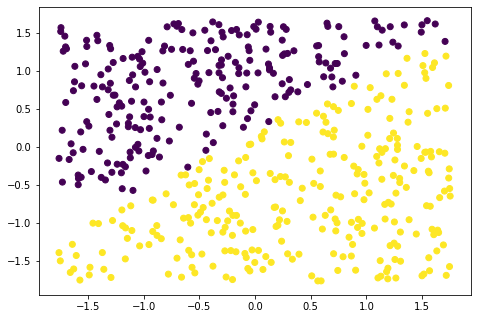

In [1507]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=output_layer[:,0]>0.5)

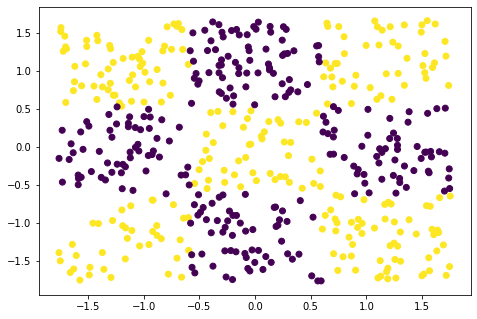

In [1508]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=true_output_layer[:,0])

In [ ]:
#nie wiem czemu siec sie tak zachowuje

# Space for debugging

In [835]:
mlp_test=MLP_test(1,1,[4,6],[sigmoid,sigmoid,identity],[sigmoid_grad,sigmoid_grad,identity_grad],MSE,MSE_grad)

In [836]:
test = np.loadtxt("mio1/regression/multimodal-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

X=test[:,0].reshape(-1,1)

Y=test[:,1].reshape(-1,1)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

In [843]:
mlp_test.train(train_input_layer,true_output_layer)

start
1009.8648194521941


KeyboardInterrupt: 

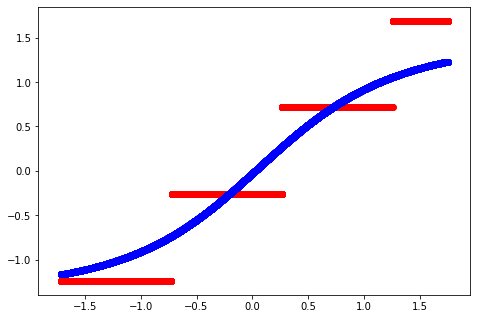

In [842]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, true_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")

In [12]:
mlp=MLP(1,1,[15,17,19],sigmoid)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

rate=0.08

beta=0.8

batch=0.2

stop=10**-6

RMSprop=True

eps=10**-8

NameError: name 'X' is not defined

In [208]:
xd=np.ones((3,2))

In [212]:
softmax(xd)

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [214]:
sigmoid(xd)

array([[0.73105858, 0.73105858],
       [0.73105858, 0.73105858],
       [0.73105858, 0.73105858]])

In [ ]:
lin=np.linspace(0,train_input_layer.shape[0],int(train_input_layer.shape[0]*batch)).round().astype(int)
output_layer=mlp.calculate(train_input_layer)
error=sum((true_output_layer-output_layer)**2)
iteration=0
old_gradient=[[0]*(len(lin)-1) for x in range(len(mlp.weights))]
old_gradient_bias=[[0]*(len(lin)-1) for x in range(len(mlp.weights))]
error_list=[error]

for xd in range(1*10**1):
    iteration+=1
    
    for b in range(len(lin)-1):
        
        input_layer=train_input_layer[lin[b]:lin[b+1]]
        output_layer=mlp.calculate(input_layer,memory=True)
        batch_size=output_layer.shape[0]
        errors=[[0]*len(mlp.weights) for x in range(batch_size)]

        for x in range(batch_size):
            #derivative of x is 1
            errors[x][-1]=((output_layer[x]-true_output_layer[lin[b]:lin[b+1]][x])).reshape(-1,1)

            for i in range(len(mlp.weights)-2,-1,-1): 
                errors[x][i]=mlp.weights[i+1].T.dot(errors[x][i+1])*sigmoid_derivative(mlp.hidden_layers[i][:,x:x+1])

        for l in range(1,len(mlp.weights)):

            if(RMSprop):
                new_gradient=sum([errors[x][l].dot(mlp.activation_function(mlp.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                old_gradient[l][b]=beta*old_gradient[l][b]+(1-beta)*new_gradient**2
                mlp.weights[l]=mlp.weights[l]-new_gradient*(rate/(np.sqrt(old_gradient[l][b])+eps))
                
                new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                old_gradient_bias[l][b]=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias**2
                mlp.biases[l]=mlp.biases[l]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[l][b])+eps))
            else:
                new_gradient=sum([errors[x][l].dot(mlp.activation_function(mlp.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                new_gradient=beta*old_gradient[l][b]+(1-beta)*new_gradient
                old_gradient[l][b]=new_gradient
                mlp.weights[l]=mlp.weights[l]-new_gradient*rate

                new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                new_gradient_bias=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias
                old_gradient_bias[l][b]=new_gradient_bias
                mlp.biases[l]=mlp.biases[l]-new_gradient_bias*rate

        if(RMSprop):
            new_gradient=sum([errors[x][0].dot((mlp.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
            old_gradient[0][b]=beta*old_gradient[0][b]+(1-beta)*new_gradient**2
            mlp.weights[0]=mlp.weights[0]-new_gradient*(rate/(np.sqrt(old_gradient[0][b])+eps))
            
            new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
            old_gradient_bias[0][b]=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias**2
            mlp.biases[0]=mlp.biases[0]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[0][b])+eps))
            print((np.sqrt(old_gradient_bias[0][b])+eps))
        else:
            new_gradient=sum([errors[x][0].dot((mlp.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
            new_gradient=beta*old_gradient[0][b]+(1-beta)*new_gradient
            old_gradient[0][b]=new_gradient
            mlp.weights[0]=mlp.weights[0]-new_gradient*rate

            new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
            new_gradient_bias=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias
            old_gradient_bias[0][b]=new_gradient_bias
            mlp.biases[0]=mlp.biases[0]-new_gradient_bias*rate
        
        
    output_layer=mlp.calculate(train_input_layer)
    new_error=sum((true_output_layer-output_layer)**2)
    error_list.append(new_error)
    
    if(iteration % 1000 == 0):
        print(iteration)
    
    if (abs(new_error-error)/(error+eps))<stop:
        print((new_error-error)/error)
        print(iteration)
        break
    
    error=new_error

# OLD LAB

In [23]:
#square large
mlp_start=MLP(1,1,[10,8,12],sigmoid)

test = np.loadtxt("mio1/regression/square-large-training.csv", delimiter=',', skiprows=1,usecols=range(1,3))

X=test[:,0].reshape(-1,1)

Y=test[:,1].reshape(-1,1)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

In [78]:
#multimodal-large
mlp_start=MLP(1,1,[10,8,12],sigmoid)

test = np.loadtxt("mio1/regression/multimodal-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

X=test[:,0].reshape(-1,1)

Y=test[:,1].reshape(-1,1)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

In [24]:
#steps-large
mlp_start=MLP(1,1,[10,8,12],sigmoid)

test = np.loadtxt("mio1/regression/steps-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

X=test[:,0].reshape(-1,1)

Y=test[:,1].reshape(-1,1)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

In [25]:
mlp_vanilla=MLP(1,1,[10,8,12],sigmoid)
mlp_vanilla.weights=mlp_start.weights.copy()
mlp_vanilla.biases=mlp_start.biases.copy()

In [26]:
mlp_vanilla_batch=MLP(1,1,[10,8,12],sigmoid)
mlp_vanilla_batch.weights=mlp_start.weights.copy()
mlp_vanilla_batch.biases=mlp_start.biases.copy()

In [27]:
mlp_RMS=MLP(1,1,[10,8,12],sigmoid)
mlp_RMS.weights=mlp_start.weights.copy()
mlp_RMS.biases=mlp_start.biases.copy()

In [28]:
mlp_momentum=MLP(1,1,[10,8,12],sigmoid)
mlp_momentum.weights=mlp_start.weights.copy()
mlp_momentum.biases=mlp_start.biases.copy()

In [35]:
error_momentum=mlp_momentum.train(train_input_layer,true_output_layer,batch=0.1)

[347.79019007]
1000
2000
2000
[27.97169648]


In [18]:
error_vanilla_batch=mlp_vanilla_batch.train(train_input_layer,true_output_layer,beta=0)

[214.80715548]
1000
2000
2000
[0.03706813]


In [19]:
error_vanilla=mlp_vanilla.train(train_input_layer,true_output_layer,batch=1,beta=0)

[214.80715548]
1000
2000
2000
[0.0089865]


In [70]:
error_RMS=mlp_RMS.train(train_input_layer,true_output_layer,RMSprop=True,beta=0.999,batch=0.1,eps=10**-8,rate=0.001)

[575.67652086]


KeyboardInterrupt: 

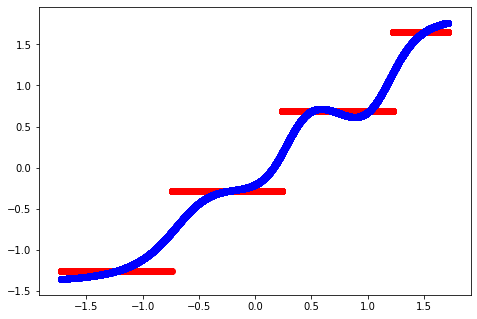

In [34]:
output_layer=mlp_momentum.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, true_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")

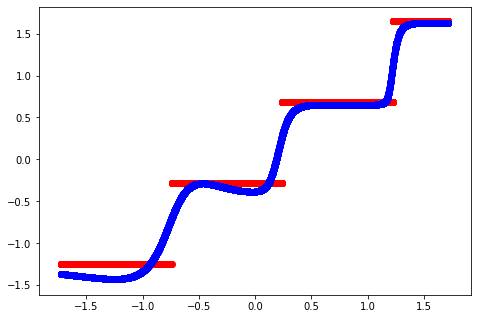

In [71]:
output_layer=mlp_RMS.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, true_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")

In [27]:
t = np.arange(1, 2002, 1)

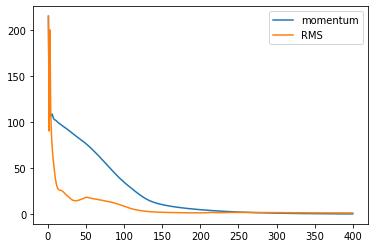

In [72]:
plt.plot(t[0:400],error_momentum[0:400],label="momentum")
plt.plot(t[0:400],error_RMS[0:400],label="RMS")
plt.legend(loc="upper right")

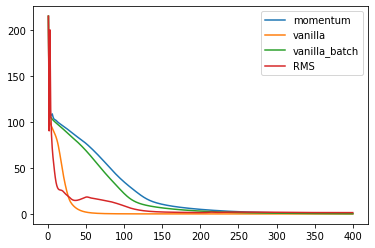

In [28]:
plt.plot(t[0:400],error_momentum[0:400],label="momentum")
plt.plot(t[0:400],error_vanilla[0:400],label="vanilla")
plt.plot(t[0:400],error_vanilla_batch[0:400],label="vanilla_batch")
plt.plot(t[0:400],error_RMS[0:400],label="RMS")
plt.legend(loc="upper right")

In [ ]:
error_momentum[-1]

In [ ]:
error_vanilla[-1]

In [ ]:
error_vanilla_batch[-1]

In [ ]:
error_RMS[-1]